In [62]:
# Slides are built using
# jupyter nbconvert --to slides --post serve AIISL.ipynb --template output_toggle.tpl

%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 120

In [63]:
# This is needed a second time because of a matplotlib bug in retina implementation
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 120

In [64]:
import numpy as np
import matplotlib.pyplot as pl
from corner import hist2d
from astropy.table import Table
import os

def ungzip(fn):
    import gzip
    import shutil
    with gzip.open('{}.gz'.format(fn), 'rb') as f_in:
        with open(fn, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

def get(url):
    from urllib import request
    with request.urlopen(url) as r:
        return r.read()
            
def download_file(url, file=None):
    if not file:
        file = url.split('/')[-1]
    with open(file, 'wb') as f:
        f.write(get(url))
            
def download_dataset(destfolder="data/",filename="photoz_dataset.txt",url="http://perso.astrophy.u-bordeaux.fr/PGratier/data/photoz_dataset.txt.gz"):
    if os.path.exists(destfolder):
        if os.path.exists("{}/{}".format(destfolder,filename)):
            print("Datafile {}{} already exists.\nDoing nothing".format(destfolder,filename))
            pass
        elif os.path.exists("data/photoz_dataset.txt.gz"):
            print("Archived datafile {}{}.gz already exists.\nUnzipping to {}{}".format(destfolder,filename,destfolder,filename))
            ungzip("{}{}".format(destfolder,filename))
        else:
            print("Datafile {}{} does not exists.\nDownloading {}{}.gz from {}.\nUnzipping to {}{}".format(destfolder,filename,destfolder,filename,url,destfolder,filename))
            download_file(url,file="{}/{}.gz".format(destfolder,filename))
            ungzip("{}/{}".format(destfolder,filename))

    else:
        print("Folder {} does not exist.\nDatafile {}{} does not exists.\nCreating folder {}.\nDownloading {}{}.gz from {}.\nUnzipping to {}{}".format(destfolder,destfolder,filename,destfolder,destfolder,filename,url,destfolder,filename))
        os.mkdir("data/")
        download_file(url,file="{}/{}.gz".format(destfolder,filename))
        ungzip("{}/{}".format(destfolder,filename))
     
download_dataset()

Datafile data/photoz_dataset.txt already exists.
Doing nothing


# An Interactive Introduction to Supervised Learning
## Pierre Gratier
### Laboratoire d'Astrophysique de Bordeaux

<br>
<div align="left">
<img src="images/logo_3DICE.png" style="width:200px"/>
<img src="images/vignette-lab.png" style="width:200px" />
</div>



# Supervised learning
0. Get a dataset consisting of:
    - a lot (>10K) of **samples** (the larger, and more diverse, the better)
    - many (few -> 100s) of **features**
    - a few (1-2) **predicted quantities**
0. Choose a quantity to optimize. For regression, one of:
     - Mean squared errors
     - Median absolute deviation
1. Train
     - Use a large fraction of the dataset (80-90%)
2. Validate hyperparameters
     - make sure not to overtrain
     - cross validation
3. Test
     - On *previously unseen* data
4. (interpret)

# But train with what ???

Whatever you want !

- linear models
- polynomials
- neural networks
- ...

# Supervised machine learning

Predict an output property knowning a set of input parameters
 - if property is discrete : classification
 - if property is continuous : regression 

<br>
<div align="left">
<img src="images/regression_tools.jpeg" style="width:700px"/>
</div>


## Toolbox: scikit-learn
http://scikit-learn.org

<br>
<div align="left">
<img src="images/sklearn.jpg" style="width:800px"/>
</div>

## scikit-learn cheat sheet
http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html#

<br>
<div align="left">
<img src="images/sklearn_cheat_sheet.jpg" style="width:700px"/>
</div>

## Scikit-learn class structures

- Common methods for families of algorithms -> easy to compare
    - regressor.fit()
    - regressor.predict()
    - regressor.score()
- Pipelines to chain algorithms e.g.:
    1. scale data
    2. reduce (increase) dimentionality
    3. cluster

# Spoiler: we've been doing machine learning for quite some time 

In [65]:
from sklearn.linear_model import LinearRegression

def linfunc(x):
    return 2*x+3

def nonlinfunc(x):
    return np.sinc(x)

def create_trainset(f, ntrain=20,ntest=1000,noise=0.,seed=1234):
    np.random.seed(seed)
    xmin, xmax = -3, 3
    x_true = np.linspace(xmin-2,xmax+2,ntest)
    x_train = np.random.uniform(xmin, xmax, ntrain)
    y_true = f(x_true)
    y_train = f(x_train)
    y_train += np.random.normal(0,noise,ntrain)
    return x_train, y_train, x_true, y_true

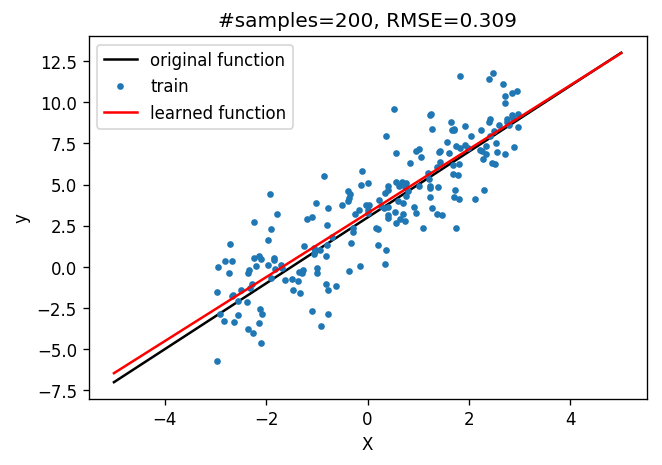

In [66]:
xtrain, ytrain, xtest, ytrue = create_trainset(linfunc, ntrain=200,ntest=1000,noise=2)
pl.plot(xtest,ytrue,'k-',label="original function")
pl.plot(xtrain,ytrain,'C0.',label='train')
reg_eg = LinearRegression()
reg_eg.fit(xtrain.reshape(-1,1), ytrain)
pred = reg_eg.predict(xtest.reshape(-1,1))
pl.plot(xtest,pred,'r-',label='learned function')
rmse = np.sqrt(((ytrue-pred)**2).mean())
pl.title("#samples={}, RMSE={:5.3f}".format(len(xtrain), rmse))
pl.legend(loc='upper left')
pl.xlabel("X")
pl.ylabel("y")
pl.show()


# Decision Trees
<br>
<div align="left">
<img src="images/Treebeard.png.jpeg" style="width:600px"/>
</div>


# Decision Trees
 - non linear machine learning algorithm
 - Can be used for classification or regression
 - Don't need to "prepare" (eg normalise, reparametrize) data
<br>
<div align="left">
<img src="images/decisiontree.gif" style="width:600px"/>
</div>

In [67]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def plot_depth(idepth, return_tree=False, **kwargs):
    pl.plot(xtest,ytrue,'k-',label="original function")
    pl.plot(xtrain,ytrain,'C0.',label='train')
    reg_eg = DecisionTreeRegressor(max_depth=idepth)
    reg_eg.fit(xtrain.reshape(-1,1), ytrain)
    pred = reg_eg.predict(xtest.reshape(-1,1))
    pl.plot(xtest,pred,'r-',label='learned function')
    rmse = np.sqrt(((ytrue-pred)**2).mean())
    pl.title("#samples={}, max depth={}, RMSE={:5.3f}".format(len(xtrain),idepth, rmse))
    pl.legend(loc='upper left')
    pl.xlabel("X")
    pl.ylabel("y")
    pl.show()
    if return_tree:
        return reg_eg

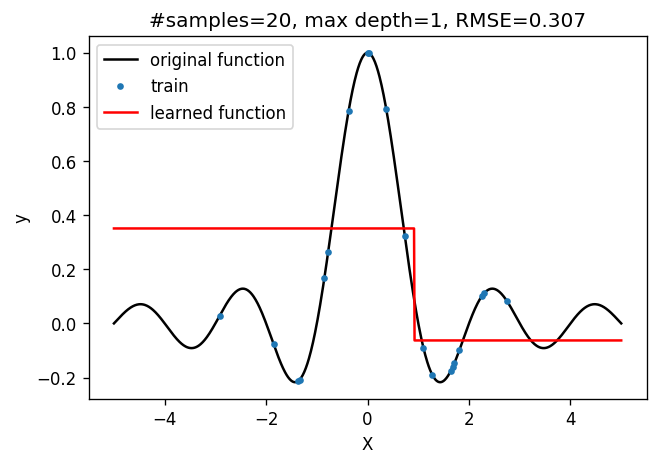

In [68]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(nonlinfunc)
singletree = plot_depth(1,return_tree=True)

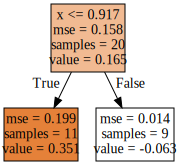

In [69]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(singletree, out_file=None, 
                         feature_names='x', filled=True)  
graph = graphviz.Source(dot_data) 
graph.render()
graph

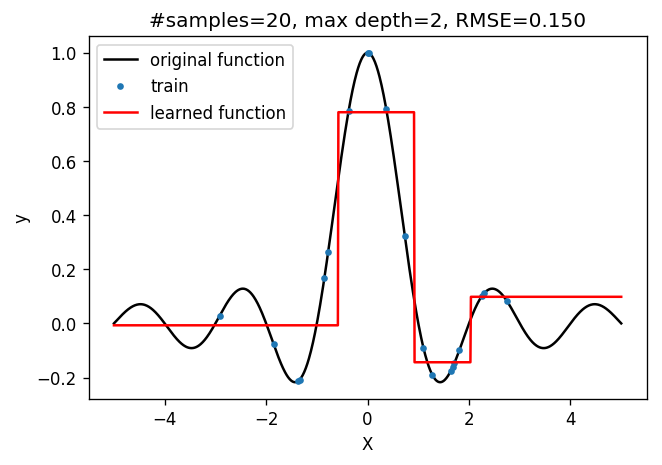

In [70]:
singletree = plot_depth(2, return_tree=True)

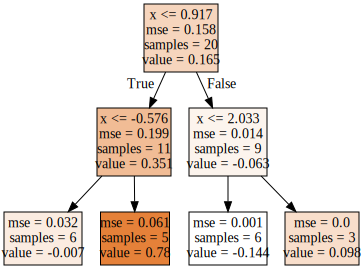

In [71]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(singletree, out_file=None, 
                         feature_names='x',filled=True)  
graph = graphviz.Source(dot_data) 
graph

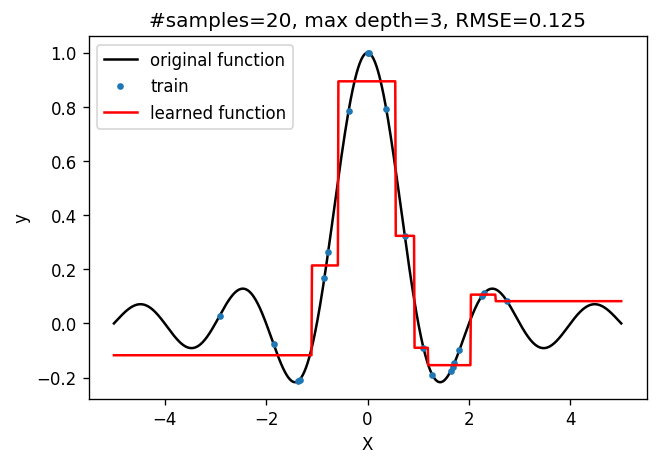

In [72]:
plot_depth(3)

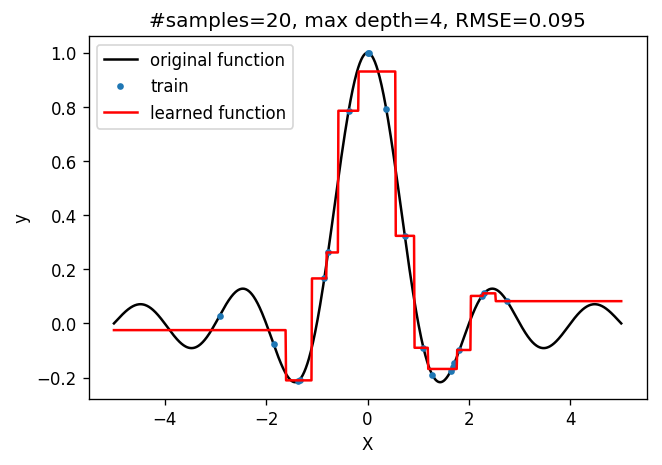

In [73]:
plot_depth(4)

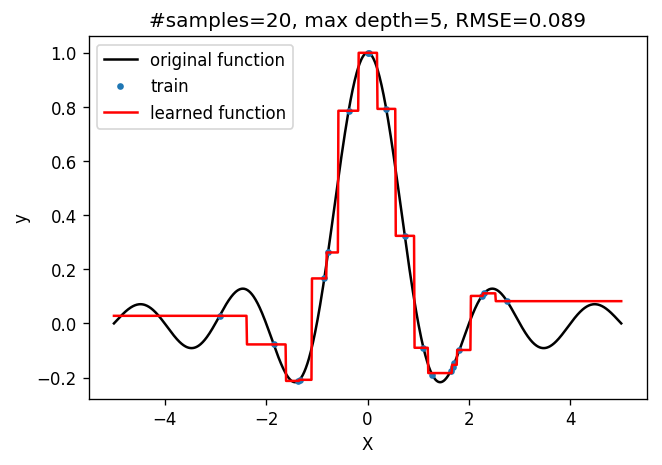

In [74]:
plot_depth(5)

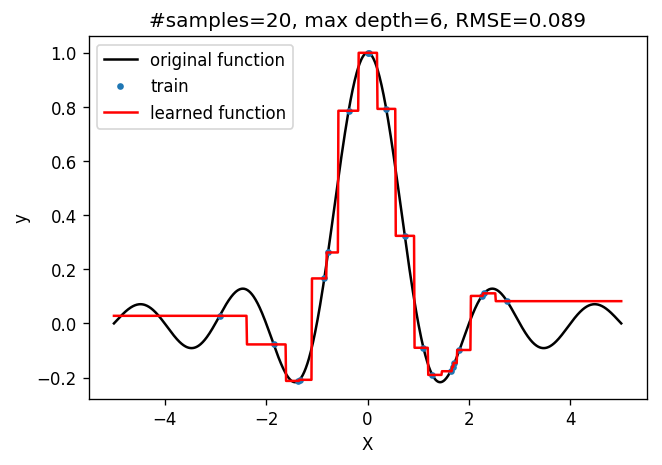

In [75]:
plot_depth(6)

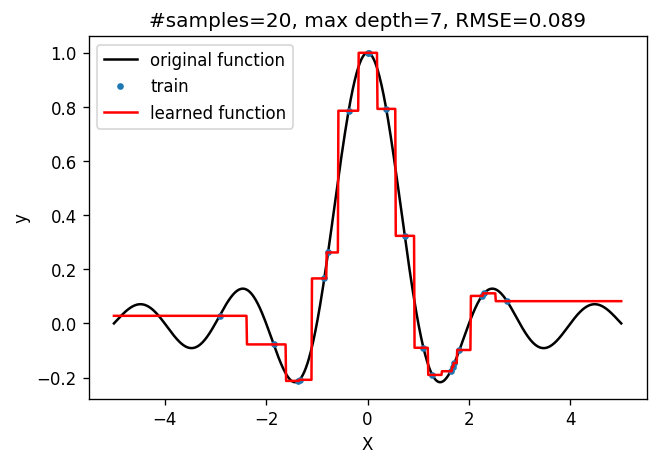

In [76]:
plot_depth(7)

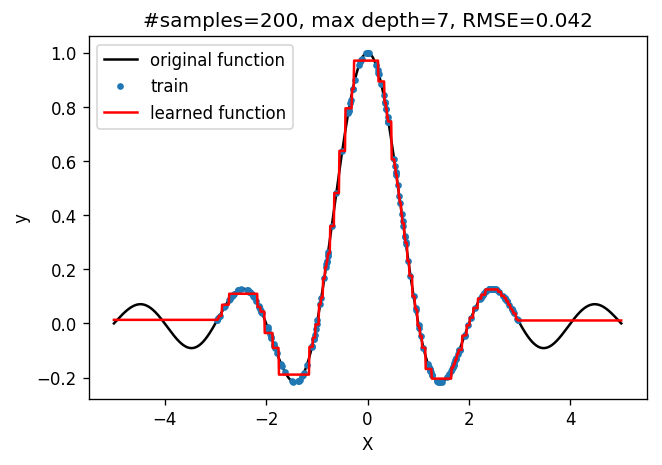

In [77]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(nonlinfunc,ntrain=200)
plot_depth(7)

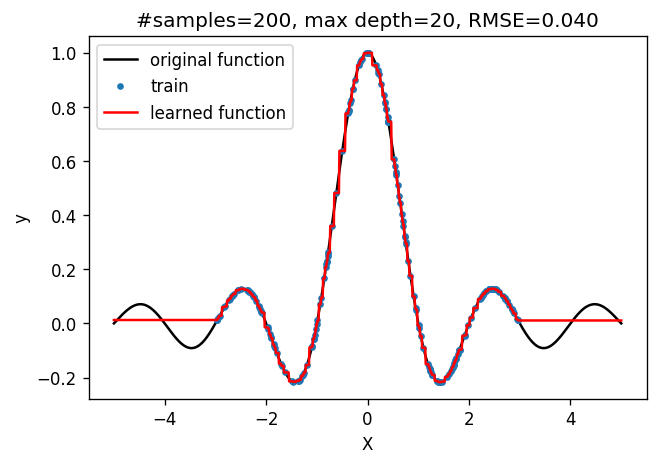

In [78]:
plot_depth(20)

# What about noise ?

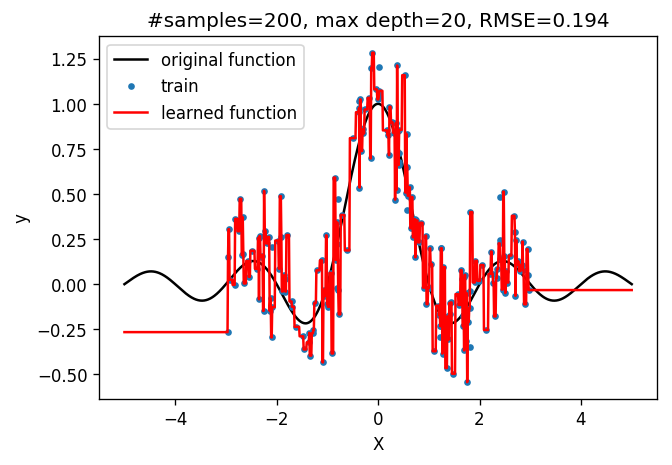

In [79]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(nonlinfunc,ntrain=200, noise=0.2)
plot_depth(20)

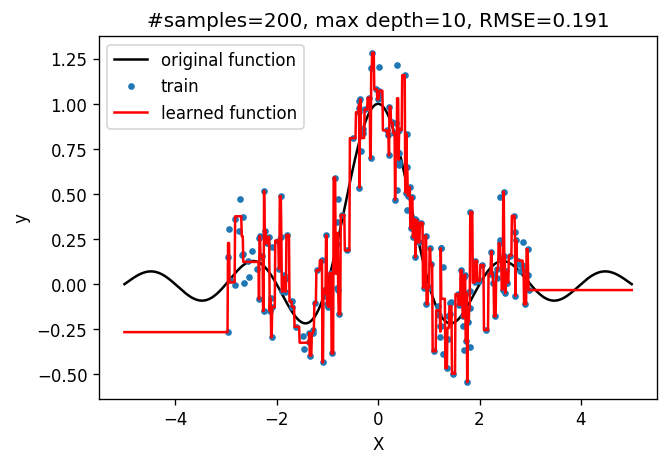

In [80]:
plot_depth(10)

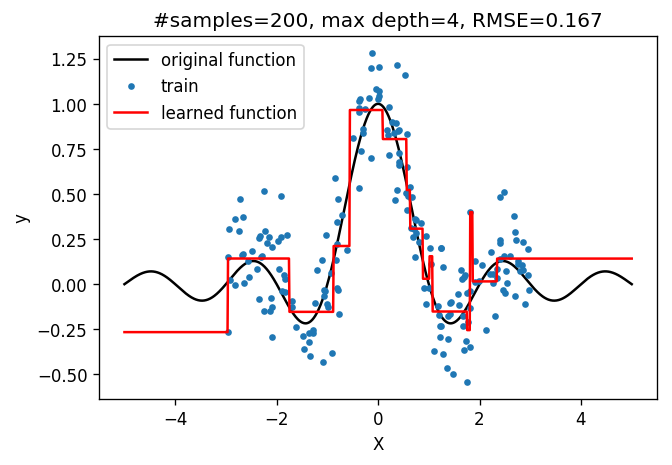

In [81]:
plot_depth(4)

# You enter the forest ... 
<br>
<div align="left">
<img src="images/forest.jpg" style="width:600px"/>
</div>

# The Random Forest
Idea:
 - train a bunch of weaker trees on random subsets of the data
     - less deep
     - only considering a subset of the features
     - ** to minimise sensitivity to overtraining**
 - average their results out 
 
Generalised to bagging methods (="bootstrap aggreggating")
 - a lot of "weak" learners can be bagged


In [82]:
def plot_depth_random_forest(idepth):
    pl.plot(xtest,ytrue,'k-',label="original function")
    pl.plot(xtrain,ytrain,'C0.',label='train')
    rf = RandomForestRegressor(500,max_depth=idepth)
    rf.fit(xtrain.reshape(-1,1), ytrain)
    pred = rf.predict(xtest.reshape(-1,1))
    for tree in rf.estimators_[:100]:
        pl.plot(xtest,tree.predict(xtest.reshape(-1,1)),'C1-',alpha=0.1)
    pl.plot(xtest,tree.predict(xtest.reshape(-1,1)),'C1-',alpha=0.1,label='individual trees')
    pl.plot(xtest,pred,'r-',label='average of trees')
    rmse = np.sqrt(((ytrue-pred)**2).mean())
    pl.title("#samples={}, max depth={}, RMSE={:5.3f}".format(len(xtrain),idepth, rmse))
    pl.xlabel("X")
    pl.ylabel("y")
    pl.legend(loc='upper left')

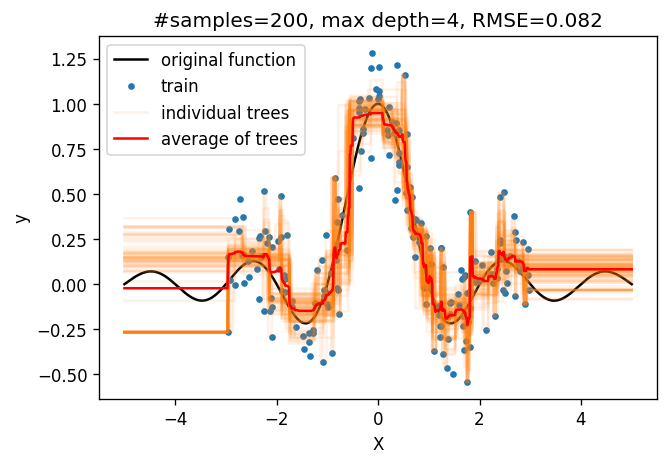

In [83]:
plot_depth_random_forest(4)

# Photometric reshift example

Estimate redshift of a galaxie without having to record a full spectrum

**Photometric redshifts for the SDSS Data Release 12** 

*Robert Beck; Laszlo Dobos; Tamas Budavari; Alexander S. Szalay; Istvan Csabai*

Monthly Notices of the Royal Astronomical Society 2016 460 (2): 1371-1381

doi: 10.1093/mnras/stw1009

http://www.vo.elte.hu/papers/2016/photoz/


# Photometric reshift example

<br>
<div align="left">
<img src="images/SDSS_filter_spec.jpeg" style="width:400px"/>
</div>
*Smolcic et al. 2006*

In [84]:
# loading all the samples (nsamples = -1) can lead to long computation times. 
# If you want to reduce these, reduce the number of samples. 
# Eg nsamples=100000

nsamples=200000

t = Table.read('data/photoz_dataset.txt', format='ascii.commented_header', data_end=nsamples)
X = np.array([t['r_mag'], t['(u-g)'], t['(g-r)'], t['(r-i)'], t['(i-z)']]).T
y = np.array(t['specz'])
t

objID,r_mag,(u-g),(g-r),(r-i),(i-z),specz,specz_err,r_mag_err,(u-g)_err,(g-r)_err,(r-i)_err,(i-z)_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1237645879573873373,20.103556,0.61777878,1.5659828,0.80243492,0.34698868,0.50467163,0.00020466947,0.12190636211279779,0.7569993424418415,0.1856641077267804,0.08918345792766323,0.16939028255106794
1237645941824356668,19.704782,1.289072,1.1333313,0.51053619,0.41262436,0.36670265,6.5150554e-05,0.0655080060003986,0.33961256317629146,0.05978348297217164,0.0364401446169884,0.06327843123851273
1237645942898230100,20.193981,0.65864944,1.6796875,0.97254181,0.42072105,0.51120573,9.6673393e-05,0.06894538211721137,0.4696232662930288,0.13246810970813222,0.04741867468974273,0.07219557530687769
1237645943434969247,17.664146,2.3386784,1.3168621,0.52295685,0.30891609,0.2178527,2.8101276e-05,0.034146275497393484,0.2086004253407079,0.017263574133549436,0.010426318102097713,0.016662031474130867
1237645943973609779,20.679634,2.8722134,1.285862,0.78954506,0.42936516,0.53021437,0.00012953312,0.08482012218868118,0.9404929344359603,0.14391915658624657,0.07034844106473559,0.10070183666858297
1237646586638631776,17.648102,1.2305584,0.77993202,0.39781952,0.19709969,0.12130364,1.3130572e-05,0.04140241865153553,0.2656704256725191,0.03141473544805958,0.020330210959204627,0.036698848342571165
1237646586638696975,17.390694,1.8147697,0.99510956,0.45385933,0.34827614,0.12077779,2.1676848e-05,0.0404870914021047,0.4983410051472198,0.03283435383999303,0.018127467166179162,0.027556321567178722
1237646586639287212,18.276638,0.63219833,1.3370743,0.44069099,0.32370758,0.27851638,3.7723737e-05,0.09077032654908011,1.2388604557839884,0.17696659585781443,0.06197666372981022,0.09387934854518722
1237646587173340066,17.29701,1.1269169,0.68570518,0.26628304,0.2367115,0.15302545,3.2831675e-05,0.04995095286032848,0.08662077996581817,0.017630657351227326,0.016086336565440434,0.03967631810790787


# Some terminology
The 4 columns *r_mag, (u-g), (g-r), (r-i), (i-z)* are called **features**

*specz* is the **predicted quantity**

A line of the table is a **sample**

Here we try to predict 1 quantity from 5 features using 1065891 samples 

# Having a look at the data
A continous histogram of redshifts

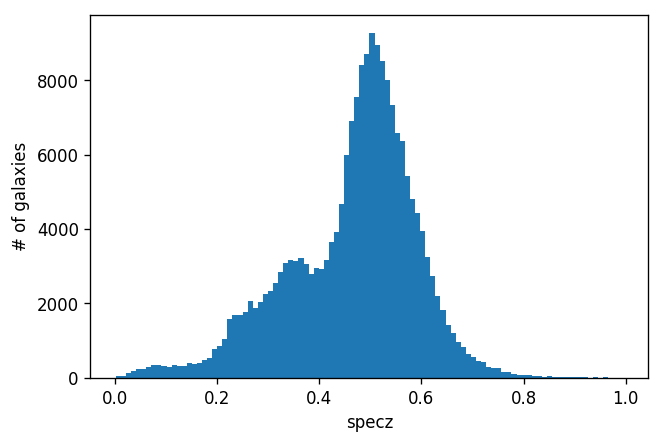

In [85]:
pl.hist(y, bins=100)
pl.xlabel('specz')
pl.ylabel('# of galaxies')
pl.show()

# Having a look at the data
Feature spaces

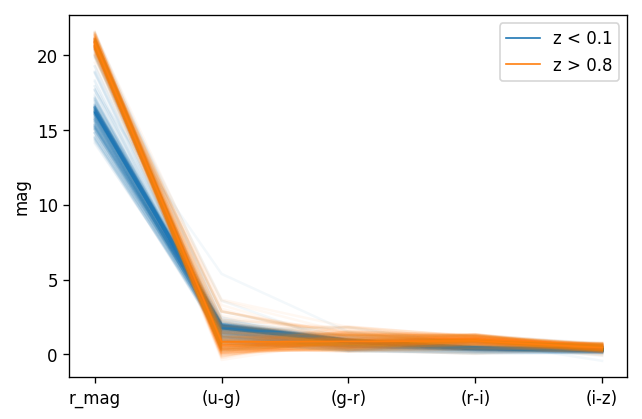

In [86]:
#low z
lowz = X[y<0.1]
for z in lowz[:200]:
    pl.plot(z,'C0',alpha=0.05)
pl.plot(np.mean(lowz,0),'C0',lw=1,label='z < 0.1')
#high z
highz = X[y>0.8]
for z in highz[:200]:
    pl.plot(z,'C1',alpha=0.05)
pl.plot(np.mean(highz,0),'C1',lw=1,label='z > 0.8')
pl.ylabel('mag')
pl.xticks([0,1,2,3,4],t.colnames[1:])
pl.xticks
pl.legend()
pl.show()

# Having a look at the data
Feature spaces (zooming in)

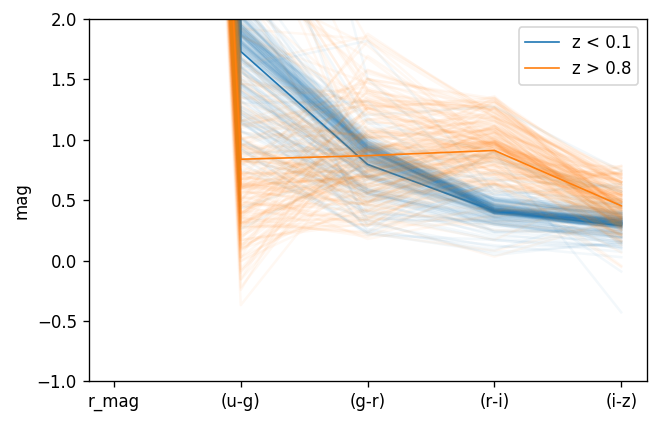

In [87]:
#low z
lowz = X[y<0.1]
for z in lowz[:200]:
    pl.plot(z,'C0',alpha=0.05)
pl.plot(np.mean(lowz,0),'C0',lw=1,label='z < 0.1')
#high z
highz = X[y>0.8]
for z in highz[:200]:
    pl.plot(z,'C1',alpha=0.05)
pl.plot(np.mean(highz,0),'C1',lw=1,label='z > 0.8')
pl.ylabel('mag')
pl.xticks([0,1,2,3,4],t.colnames[1:])
pl.ylim([-1,2])
pl.xticks
pl.legend()
pl.show()

# Check a linear model to have a benchmark for the improvement

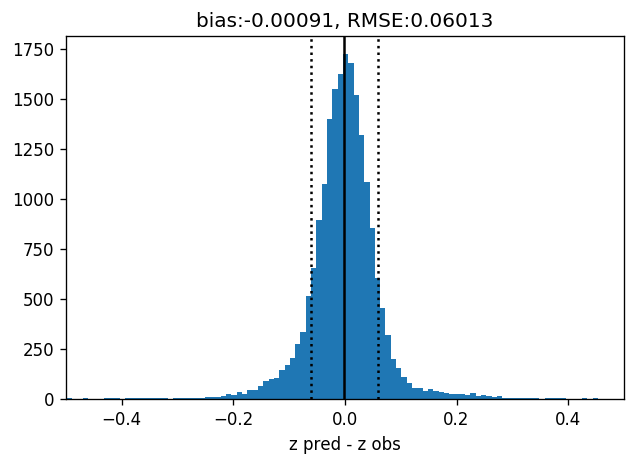

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)

reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_linear = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse,color='k',ls=':')
pl.axvline(bias+rmse,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse))
pl.show()

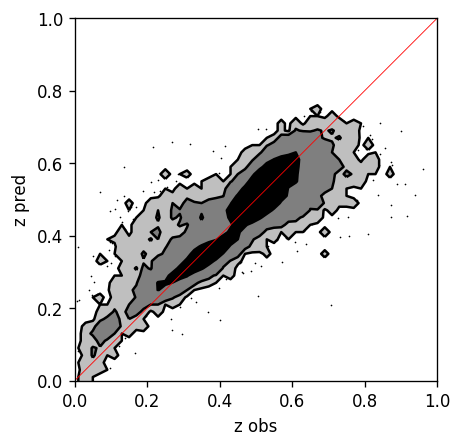

In [89]:
fig, ax = pl.subplots()
hist2d(y_test,y_pred,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_ylabel("z pred")
ax.set_xlabel("z obs")
pl.plot([0,1],[0,1],'r-',lw=0.5)
pl.show()

# Out of the box random forest 

CPU times: user 19.3 s, sys: 179 ms, total: 19.5 s
Wall time: 3.81 s
CPU times: user 219 ms, sys: 44.7 ms, total: 264 ms
Wall time: 105 ms


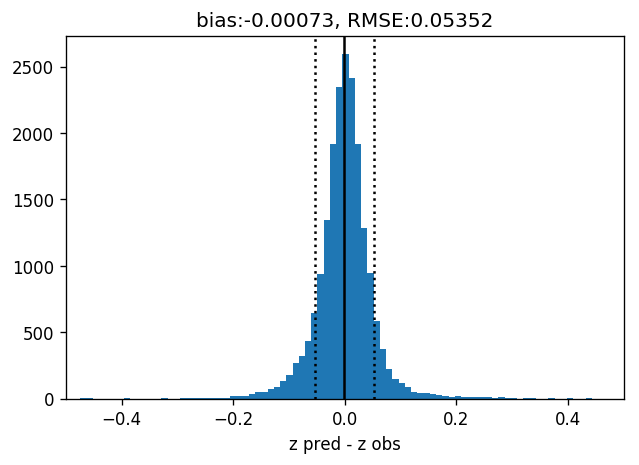

In [90]:
np.random.seed(1234)
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_jobs=8, random_state=1234)

%time fit = rf.fit(X_train, y_train)
%time y_pred = rf.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_default = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse_default,color='k',ls=':')
pl.axvline(bias+rmse_default,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse_default))
pl.show()

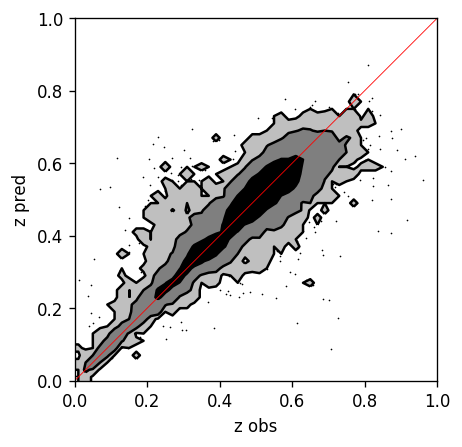

In [91]:
fig, ax = pl.subplots()
hist2d(y_test,y_pred,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_ylabel("z pred")
ax.set_xlabel("z obs")
pl.plot([0,1],[0,1],'r-',lw=0.5)
pl.show()

# Results 


In [92]:
print("A full {:5.2f}% improvement of the root mean squared error FTW !!".format(100*(1-rmse_default/rmse_linear)))

A full 10.99% improvement of the root mean squared error FTW !!


But there are a lot of parameters of the random forest we should be able to tweak !

Parameters of a learning algorithm = **hyperparameters**

In [93]:
for key, value in rf.get_params().items():
    print("{:<30}:{}".format(key, value))

bootstrap                     :True
criterion                     :mse
max_depth                     :None
max_features                  :auto
max_leaf_nodes                :None
min_impurity_decrease         :0.0
min_impurity_split            :None
min_samples_leaf              :1
min_samples_split             :2
min_weight_fraction_leaf      :0.0
n_estimators                  :10
n_jobs                        :8
oob_score                     :False
random_state                  :1234
verbose                       :0
warm_start                    :False


# How do we choose the best values ?
### Cross validation 

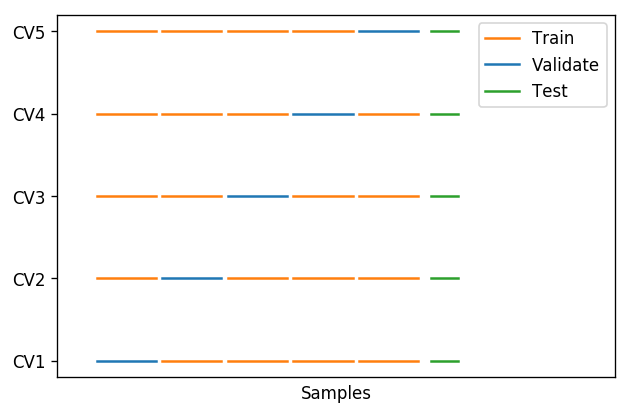

In [94]:
fig, ax = pl.subplots(1)
y_pos = 0
x_pos = np.arange(5)
for j in range(5):
    for i in range(5):
        if (i==j):
            color = 'C0'
        else:
            color = 'C1'
        pl.plot([x_pos[i]+.1,x_pos[i]+1],[j,j],color=color)
        
for j in range(5):
    pl.plot([x_pos[-1]+1.2,x_pos[-1]+1.6],[j,j],color='C2')

pl.plot([0,0],[0,0],color='C1',label='Train')
pl.plot([0,0],[0,0],color='C0',label='Validate')
pl.plot([0,0],[0,0],color='C2',label='Test')
pl.xlim([-.50,8])
pl.yticks(range(0,5),['CV{}'.format(i+1) for i in range(5)])
pl.xticks([])
pl.xlabel('Samples')
pl.legend()
pl.show()

## An obvious choice of hyperparameter: `n_estimators`

In [95]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'n_estimators': list(map(int,np.logspace(1,2.3,5))), 
  },
 ]
GridSearchRF = GridSearchCV(rf,param_grid,scoring='neg_mean_squared_error',cv=5,verbose=0,n_jobs=8,return_train_score=True)
out = GridSearchRF.fit(X_train[:10000], y_train[:10000])

In [96]:
GridSearchRF.cv_results_
param = GridSearchRF.cv_results_['param_n_estimators'].data
mean_time = GridSearchRF.cv_results_['mean_fit_time']
std_time = GridSearchRF.cv_results_['std_fit_time']
mean_train = GridSearchRF.cv_results_['mean_train_score']
mean_test = GridSearchRF.cv_results_['mean_test_score']
std_train = GridSearchRF.cv_results_['std_train_score']
std_test = GridSearchRF.cv_results_['std_test_score']

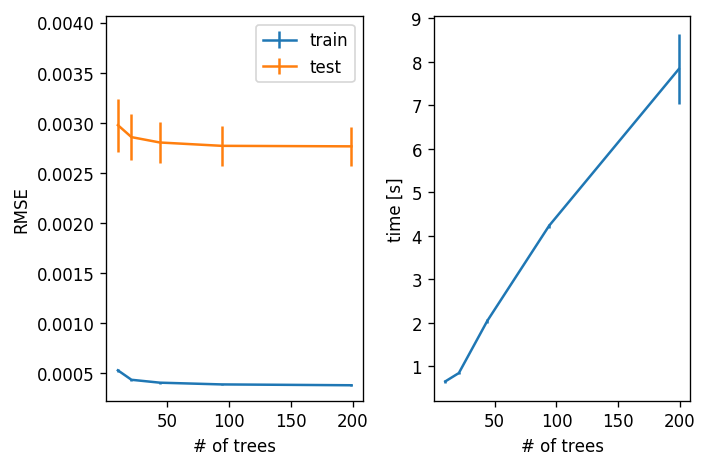

In [97]:
fig,ax = pl.subplots(1,2)
ax[0].errorbar(param,-mean_train,std_train,label='train')
ax[0].errorbar(param,-mean_test,std_test,label='test')
ax[0].legend()
ax[0].set_xlabel('# of trees')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(ymax=1.2*ax[0].get_ylim()[1])
ax[1].errorbar(param,mean_time,std_time)
ax[1].set_ylabel('time [s]')
ax[1].set_xlabel('# of trees')
pl.tight_layout()

# Exploring hyperparameter space
`max_features` and `max_depth`

In [98]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'max_features': [1, 2, 3, 4, 5], 
   'max_depth': list(range(1,20,2))
  },
 ]
rf.set_params(n_estimators=10)
GridSearchRF = GridSearchCV(rf,param_grid,scoring='neg_mean_squared_error',cv=5,verbose=0,n_jobs=8,return_train_score=True,refit=False)
out = GridSearchRF.fit(X_train, y_train)
best_params = out.best_params_

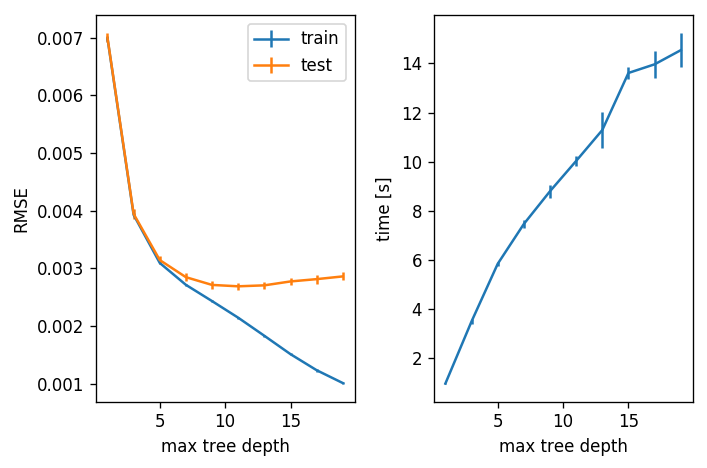

In [99]:
param = np.unique(GridSearchRF.cv_results_['param_max_depth'].data)
mean_time = GridSearchRF.cv_results_['mean_fit_time'].reshape(-1,5)[:,3]
std_time = GridSearchRF.cv_results_['std_fit_time'].reshape(-1,5)[:,3]
mean_train = GridSearchRF.cv_results_['mean_train_score'].reshape(-1,5)[:,3]
mean_test = GridSearchRF.cv_results_['mean_test_score'].reshape(-1,5)[:,3]
std_train = GridSearchRF.cv_results_['std_train_score'].reshape(-1,5)[:,3]
std_test = GridSearchRF.cv_results_['std_test_score'].reshape(-1,5)[:,3]

fig,ax = pl.subplots(1,2)
ax[0].errorbar(param,-mean_train,std_train,label='train')
ax[0].errorbar(param,-mean_test,std_test,label='test')
ax[0].legend()
ax[0].set_xlabel('max tree depth')
ax[0].set_ylabel('RMSE')
ax[1].errorbar(param,mean_time,std_time)
ax[1].set_ylabel('time [s]')
ax[1].set_xlabel('max tree depth')
pl.tight_layout()

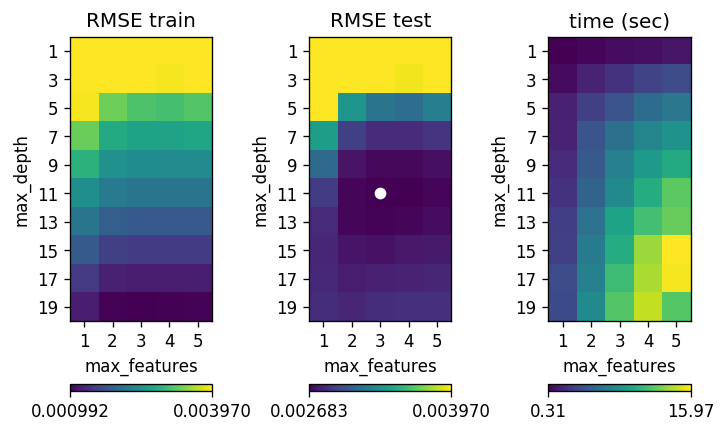

In [100]:
mean_train = -GridSearchRF.cv_results_['mean_train_score']
mean_test = -GridSearchRF.cv_results_['mean_test_score']
std_train = GridSearchRF.cv_results_['std_train_score']
std_test = GridSearchRF.cv_results_['std_test_score']
mean_time = GridSearchRF.cv_results_['mean_fit_time']
std_time = GridSearchRF.cv_results_['std_fit_time']

fig,axes = pl.subplots(1,3)
im0 = axes[0].imshow(mean_train.reshape(-1,5),vmin=mean_train.min(),vmax=4*mean_train.min())
pl.colorbar(im0,orientation='horizontal',ax=axes[0],ticks=[im0.norm.vmin,im0.norm.vmax])
axes[0].set_title('RMSE train')
im1 = axes[1].imshow(mean_test.reshape(-1,5),vmin=mean_test.min(), vmax=4*mean_train.min())
pl.colorbar(im1,orientation='horizontal',ax=axes[1],ticks=[im1.norm.vmin,im1.norm.vmax])
# axes[1].plot([best_params['max_depth'],best_params['max_features']],'wo')
axes[1].plot(best_params['max_features']-1,[11./2-0.5],'wo')
axes[1].set_title('RMSE test')
im2 = axes[2].imshow(mean_time.reshape(-1,5))
pl.colorbar(im2,orientation='horizontal',ax=axes[2],ticks=[im2.norm.vmin,im2.norm.vmax])
axes[2].set_title('time (sec)')
for ax in axes:
    ax.set_xticks(np.array(param_grid[0]['max_features'])-1)
    ax.set_yticks(np.array(param_grid[0]['max_depth'])/2.-0.5)
    ax.set_xticklabels(param_grid[0]['max_features'])
    ax.set_yticklabels(param_grid[0]['max_depth'])
    ax.set_xlabel('max_features')
    ax.set_ylabel('max_depth')
pl.tight_layout()


Best parameters:

In [101]:
for key, value in best_params.items():
    print("{:<30}:{}".format(key, value))
    


max_depth                     :11
max_features                  :3


### Optimized Random Forest

CPU times: user 7.7 s, sys: 62.6 ms, total: 7.76 s
Wall time: 1.55 s
CPU times: user 33.1 ms, sys: 4.84 ms, total: 37.9 ms
Wall time: 104 ms


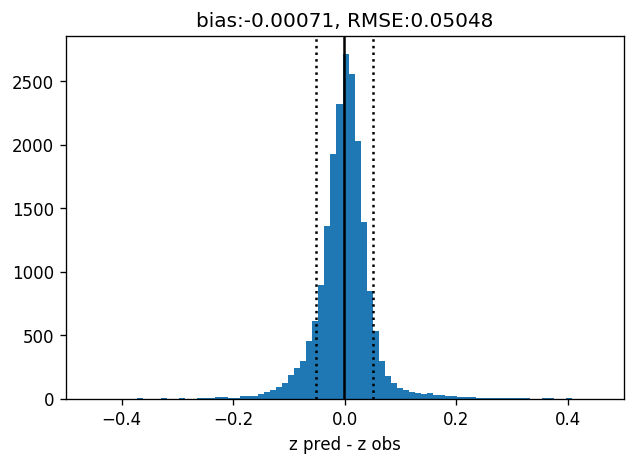

In [102]:
np.random.seed(1234)
rf = RandomForestRegressor(n_estimators=10,max_depth=best_params['max_depth'],max_features=best_params['max_features'], n_jobs=8, random_state=1234)

%time fit = rf.fit(X_train, y_train)
%time y_pred = rf.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_optimised = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse_optimised,color='k',ls=':')
pl.axvline(bias+rmse_optimised,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse_optimised))
pl.show()

## Improvement


In [103]:
print("For 10 trees a {:5.2f}% improvement from standard RF parameters".format(100*(1-rmse_optimised/rmse_default)))

For 10 trees a  5.68% improvement from standard RF parameters


# Final run
A large forest with optimized hyperparameters

CPU times: user 2min 42s, sys: 683 ms, total: 2min 43s
Wall time: 23.4 s


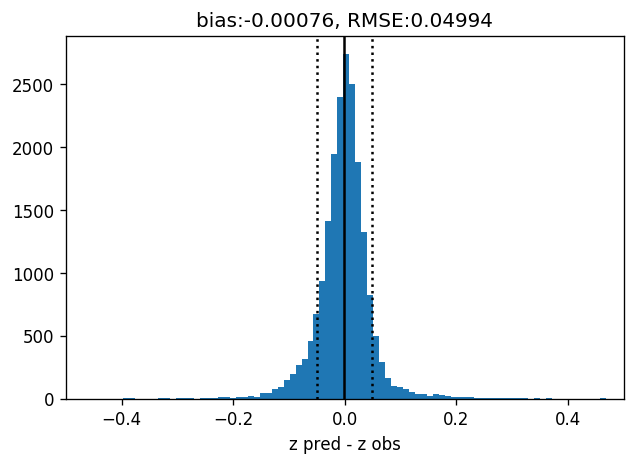

In [104]:
np.random.seed(1234)
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators=200,max_depth=best_params['max_depth'],max_features=best_params['max_features'], n_jobs=8, random_state=1234)

%time fit = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

diff = y_pred-y_test
bias = np.mean(diff)
rmse = np.sqrt(np.mean(diff**2))
rmse_optimised_many_trees = rmse.copy()

pl.hist(diff, bins=100)
pl.axvline(bias,color='k')
pl.axvline(bias-rmse,color='k',ls=':')
pl.axvline(bias+rmse,color='k',ls=':')
pl.xlim([-0.5,0.5])
pl.xlabel("z pred - z obs")
pl.title("bias:{:6.5f}, RMSE:{:4.5f}".format(bias, rmse))
pl.show()

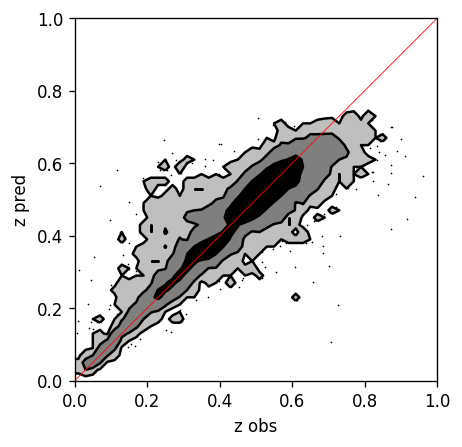

In [105]:
fig, ax = pl.subplots()
hist2d(y_test,y_pred,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_ylabel("z pred")
ax.set_xlabel("z obs")
pl.plot([0,1],[0,1],'r-',lw=0.5)
pl.show()

## Final improvement


In [106]:
print("For a forest of {} trees and optimised parameters:\n - {:5.2f}% improvement from standard RF parameters \n - {:5.2f}% improvement from a linear model.".format(rf.get_params()['n_estimators'],100*(1-rmse_optimised_many_trees/rmse_default),100*(1-rmse_optimised_many_trees/rmse_linear)))

For a forest of 200 trees and optimised parameters:
 -  6.69% improvement from standard RF parameters 
 - 16.95% improvement from a linear model.


# Interpreting results
## Feature importance

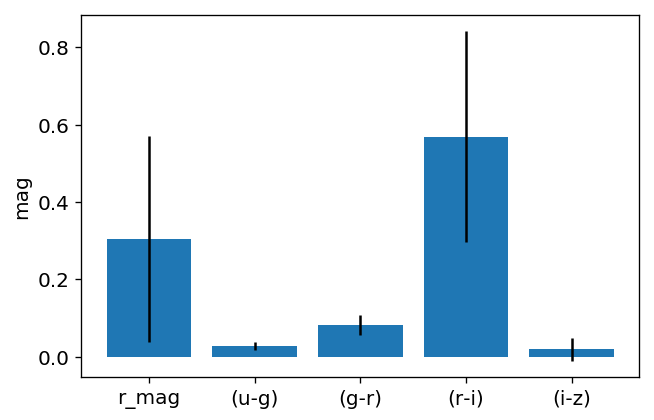

In [139]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

pl.bar(range(5),rf.feature_importances_,yerr=std)
pl.ylabel('mag')
pl.xticks([0,1,2,3,4],t.colnames[1:])
pl.xticks
pl.show()

# Interpreting results
## Individual contribution

In [108]:
from treeinterpreter import treeinterpreter as ti
nsamples = 5
lowz_features = X_test[y_test<0.1][:nsamples]
lowz_specz = y_test[y_test<0.1][:nsamples]

highz_features = X_test[y_test>0.8][:nsamples]
highz_specz = y_test[y_test>0.8][:nsamples]
format_str = "spec z:{:5.2f} photo z:{:5.2f} = {:5.2f} + {:5.2f} x " + " + {:5.2f} x ".join(t.colnames[1:6])
prediction, bias, contributions = ti.predict(rf, lowz_features)
for o, p, b, c in zip(lowz_specz, prediction, bias, contributions):
    print(format_str.format(o,p,b,*c))
print("")
prediction, bias, contributions = ti.predict(rf, highz_features)
for o, p, b, c in zip(highz_specz, prediction, bias, contributions):
    print(format_str.format(o,p,b,*c))


spec z: 0.08 photo z: 0.07 =  0.46 + -0.17 x r_mag + -0.00 x (u-g) + -0.08 x (g-r) + -0.13 x (r-i) + -0.00 x (i-z)
spec z: 0.05 photo z: 0.07 =  0.46 + -0.17 x r_mag + -0.00 x (u-g) + -0.08 x (g-r) + -0.12 x (r-i) + -0.01 x (i-z)
spec z: 0.06 photo z: 0.06 =  0.46 + -0.19 x r_mag + -0.00 x (u-g) + -0.08 x (g-r) + -0.13 x (r-i) + -0.00 x (i-z)
spec z: 0.06 photo z: 0.10 =  0.46 + -0.13 x r_mag + -0.01 x (u-g) + -0.09 x (g-r) + -0.13 x (r-i) + -0.00 x (i-z)
spec z: 0.05 photo z: 0.13 =  0.46 + -0.16 x r_mag + -0.01 x (u-g) + -0.04 x (g-r) + -0.14 x (r-i) +  0.00 x (i-z)

spec z: 0.84 photo z: 0.51 =  0.46 +  0.12 x r_mag +  0.03 x (u-g) +  0.01 x (g-r) + -0.14 x (r-i) +  0.03 x (i-z)
spec z: 0.94 photo z: 0.51 =  0.46 +  0.09 x r_mag +  0.02 x (u-g) +  0.03 x (g-r) + -0.13 x (r-i) +  0.03 x (i-z)
spec z: 0.96 photo z: 0.57 =  0.46 +  0.03 x r_mag + -0.00 x (u-g) + -0.00 x (g-r) +  0.09 x (r-i) + -0.01 x (i-z)
spec z: 0.84 photo z: 0.63 =  0.46 + -0.00 x r_mag +  0.03 x (u-g) +  0.04 x (g

# Be wary of extrapolation
Your data live in a lower dimentional subset of the parameter space. Not all combinations of features represent a physical observation.

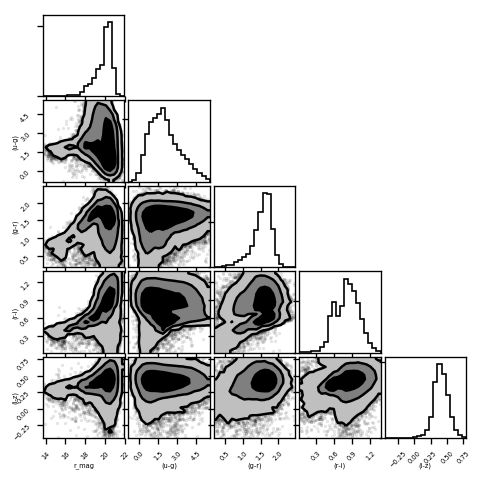

In [128]:
from matplotlib import rcParams
rcParams["font.size"] = 4
import corner
fig = corner.corner(X,labels=t.colnames[1:],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,)
fig.set_size_inches(4,4)
rcParams["font.size"] = 12

## Detecting outliers

In [131]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(n_jobs=8,random_state=1234)
IF.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=8, random_state=1234,
        verbose=0)

In [132]:
outlier_prediction = IF.predict(X_test)
outlier_decision = IF.decision_function(X_test)
point = np.array([1.,1.,1.,1.,1.])
print("Decision function for [{},{},{},{},{}]: {}".format(*point,IF.decision_function(point.reshape(1,-1))))
print("Outlier prediction for [{},{},{},{},{}]: {}".format(*point,IF.predict(point.reshape(1,-1))))

point = np.array([20.,1.5,1.5,0.7,0.5])
print("Decision function for [{},{},{},{},{}]: {}".format(*point,IF.decision_function(point.reshape(1,-1))))
print("Outlier prediction for [{},{},{},{},{}]: {}".format(*point,IF.predict(point.reshape(1,-1))))

point = np.array([200.,1.,1.,1.,1.])
print("Decision function for [{},{},{},{},{}]: {}".format(*point,IF.decision_function(point.reshape(1,-1))))
print("Outlier prediction for [{},{},{},{},{}]: {}".format(*point,IF.predict(point.reshape(1,-1))))

print("Proportion of false negative (points identified as outliers although in the train set): {:5.1f}%".format((outlier_prediction == -1).sum()/len(outlier_prediction) * 100))


Decision function for [1.0,1.0,1.0,1.0,1.0]: [-0.13084888]
Outlier prediction for [1.0,1.0,1.0,1.0,1.0]: [-1]
Decision function for [20.0,1.5,1.5,0.7,0.5]: [0.10206455]
Outlier prediction for [20.0,1.5,1.5,0.7,0.5]: [1]
Decision function for [200.0,1.0,1.0,1.0,1.0]: [-0.05016623]
Outlier prediction for [200.0,1.0,1.0,1.0,1.0]: [-1]
Proportion of false negative (points identified as outliers although in the train set):   9.9%


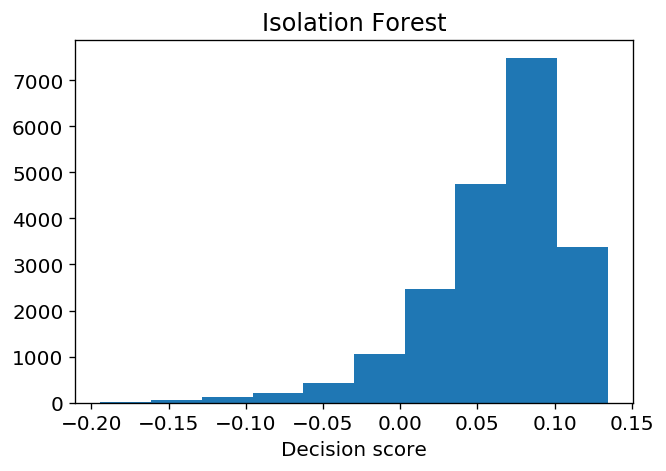

In [135]:
pl.hist(outlier_decision)
pl.xlabel("Decision score")
pl.title("Isolation Forest")
pl.show()

# Uncertainty on the prediction ?
Quantile regression

In [113]:
#Ugly hack because scikit-garden requires numpy to be installed before (see https://github.com/scikit-garden/scikit-garden/issues/23)
import pip
def install(package):
    pip.main(['install', package])
_ = install('scikit-garden')

In [136]:
from skgarden import RandomForestQuantileRegressor
rfqr = RandomForestQuantileRegressor(max_depth=best_params['max_depth'],max_features=best_params['max_features'], n_jobs=8, random_state=1234)
fit = rfqr.fit(X_train, y_train)

In [115]:
np.random.seed(1234)
nsample = 5000
if nsample>len(X_test):
    print("No more samples than samples in the test set")
else:
    idx_subset = np.random.randint(0,len(X_test)+1,nsample)
    sorted_idx_samples = np.argsort(y_test[idx_subset])
    X_values = X_test[idx_subset][sorted_idx_samples]
    y_values = y_test[idx_subset][sorted_idx_samples]

    pred_med = rfqr.predict(X_values,quantile=50)
    pred_1sigm = rfqr.predict(X_values,quantile=15.87)
    pred_1sigp = rfqr.predict(X_values,quantile=84.13)
    pred_2sigm = rfqr.predict(X_values,quantile=2.28)
    pred_2sigp = rfqr.predict(X_values,quantile=97.73)

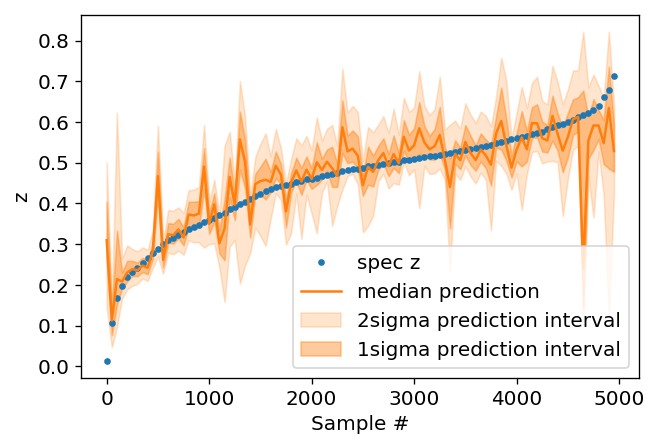

In [137]:
decimate = 50
pl.fill_between(range(nsample)[::decimate],pred_2sigm[::decimate],pred_2sigp[::decimate],color='C1',alpha=0.2,label='2sigma prediction interval')
pl.fill_between(range(nsample)[::decimate],pred_1sigm[::decimate], pred_1sigp[::decimate],color='C1',alpha=0.4,label='1sigma prediction interval')
pl.plot(range(nsample)[::decimate],y_values[::decimate],'C0',marker='.',ls='none',label='spec z')
pl.plot(range(nsample)[::decimate],pred_med[::decimate],'C1',label='median prediction')
pl.legend(loc='lower right')
pl.xlabel("Sample #")
pl.ylabel("z")
pl.show()

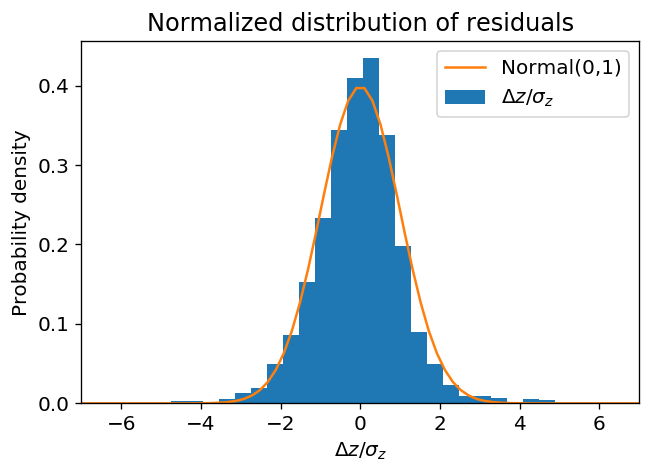

In [138]:
import scipy.stats as stats
_ = pl.hist((pred_med-y_values)/(0.5*(pred_1sigp-pred_1sigm)),bins=50,density=True,label="$\Delta z/\sigma_z$")
xvec = np.linspace(-10,10,100)
pl.plot(xvec, stats.norm.pdf(xvec),label='Normal(0,1)')
pl.legend()
pl.xlabel("$\Delta z/\sigma_z$")
pl.ylabel("Probability density")
pl.xlim([-7,7])
pl.title("Normalized distribution of residuals")
pl.show()

# Conclusion
Supervised learning is very general, it can be used both for:
 - regression
 - classification
 
Scikit-learn is good to prototype and test 

There are many more algorithms, in particular Neural Networks that can take into account:
 - spatial correlations (Convolutional NN)
 - time dependance (Recurrent NN)

Other packages for that

## scikit-learn cheat sheet
http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html#

<br>
<div align="left">
<img src="images/sklearn_cheat_sheet.jpg" style="width:700px"/>
</div>